# How to implement a simple RNN

This tutorial on implementing recurrent neural networks (RNNs) will build on [the previous tutorial on how to implement a feedforward neural network]({% post_url 2015-06-10-neural-network-implementation-part01 %}). Please check out this previous tutorial if you are unfamiliar with neural network basics such as backpropagation.

This first part will illustrate how to implement a [simple RNN](#Linear-recurrent-neural-network) and how to train it with [Backpropagation through time](#Training-with-backpropagation-through-time) using [Rprop](#Rprop-optimisation) optimization. [Part 2]({% post_url 2015-09-27-rnn-implementation-part02 %}) will describe how to build a more complex RNN with non-linear activations and tensor inputs.


## Recurrent neural networks

[Recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs) are neural nets that can deal with sequences of variable length (unlike feedforward nets). They are able to this by defining a [recurrence relation](https://en.wikipedia.org/wiki/Recurrence_relation) over timesteps which is typically the following formula:

$$
S_{k} = f(S_{k-1} \cdot W_{rec} + X_k \cdot W_x)
$$

Where $S_k$ is the state at time $k$, $X_k$ an exogenous input at time $k$, $W_{rec}$ and $W_x$ are parameters like the weights parameters in feedforward nets. Note that the RNN can be viewed as a state model with a [feedback loop](https://en.wikipedia.org/wiki/Feedback). The state evolves over time due to the recurrence relation, and the feedback is fed back into the state with a delay of one timestep. This delayed feedback loop gives the model memory because it can remember information between timesteps in the states.  
The final output of the network $Y_k$ at a certain timestep $k$ is typically computed from one or more states $S_{k-i} \cdots S_{k+j}$.

Note that we can either compute the current state $S_{k}$ from the current input $X_k$ and previous state $S_{k-1}$, or predict the next state from $S_{k+1}$ from the current state $S_k$ and current input $X_k$. The difference of notation has not much effect on our model and depends on the task at hand.

This tutorial will illustrate that recurrent nets are not much different from feedforward nets, but there are some difficulties in training them as will be explained later.

## Linear recurrent neural network

The first part of this tutorial describes a simple RNN that is trained to count how many 1's it sees on a binary input stream, and output the total count at the end of the sequence.

The RNN model used here has one state, takes one input element from the binary stream each timestep, and outputs its last state at the end of the sequence. This model is shown in the figure below. The left part is a graphical illustration of the recurrence relation it describes ($ s_{k} = s_{k-1} \cdot w_{rec} + x_k \cdot w_x $). The right part illustrates how the network is unfolded through time over a sequence of length n. Notice that the unfolded network can be viewed as an (n+1)-layer neural network with the same shared parameters $w_{rec}$ and $w_x$ in each layer.

![Structure of the linear RNN](/images/RNN_implementation/SimpleRNN01.png)

We can easiliy see that the optimal parameters for this task would be $w_{rec} = w_x = 1$. Nevertheles the training and implementation of this neural net will be interesting.

In [1]:
# Imports
%matplotlib notebook

import sys
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

## Define the dataset

The input data $X$ used in this example consists of 20 binary sequences of 10 timesteps each. Each input sequence is generated from a uniform random distribution which is rounded to $0$ or $1$.

The output targets $t$ are the number of times '1' occurs in the sequence, which is equal to the sum of that sequence since the sequence is binary.

In [2]:
# Create dataset
nb_of_samples = 20
sequence_len = 10
# Create the sequences
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Create the targets for each sequence
t = np.sum(X, axis=1)
#

## Training with backpropagation through time

The typical algorithm to train recurrent nets is the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) algorithm. The name already implies that it is based on the backpropagation algorithm we discussed in the [previous tutorial on feedforward nets]({% post_url 2015-06-10-neural-network-implementation-part03 %}).

If you understand regular [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm, then backpropagation through time is not much more difficult to understand. The only main difference is that the recurrent net needs to be unfolded through time for a certain amount of timesteps. This unfolding is illustrated in the figure at the beginning of this tutorial. After unfolding the network, we end up with a model quite similar to a regular multilayer feedforward network. The only differences are that each layer has multiple inputs (The previous state and the current input) and that the parameters (here: $w_{rec}$ and $w_x$) are shared between each layer.


### Compute the output with the forward step

The forward step will unroll the network, and compute the forward activations just as in regular backpropagation. The final output will be used to compute the loss function from which the error signal used for training will be derived.

When unfolding a recurrent net over multiple timesteps each layer computes the same recurrence relation on different timesteps. This recurrence relation for our model is defined in the `update_state` method.

The `forward_states` method computes the states over increasing timesteps by applying the `update_state` method in a for-loop. Note that the forward steps for multiple sequences can be computed in parallel by use of vectorisation, as was illustrated in the [previous tutorial on feedforward nets]({% post_url 2015-06-10-neural-network-implementation-part04 %}).
Since the network begins without seeing anything of the sequence, an initial state needs to be provided. In this example, this initial state is set to $0$ (it is possible to treat it as another parameter).

Finally, the loss $\xi$ (`loss`) at the output is computed in this example via the mean squared error function (MSE) over all sequences in the input data.

In [3]:
# Define the forward step functions

def update_state(xk, sk, wx, wRec):
    """
    Compute state k from the previous state (sk) and current 
    input (xk), by use of the input weights (wx) and recursive 
    weights (wRec).
    """
    return xk * wx + sk * wRec


def forward_states(X, wx, wRec):
    """
    Unfold the network and compute all state activations 
    given the input X, input weights (wx), and recursive weights 
    (wRec). Return the state activations in a matrix, the last 
    column S[:,-1] contains the final activations.
    """
    # Initialise the matrix that holds all states for all 
    #  input sequences. The initial state s0 is set to 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))
    # Use the recurrence relation defined by update_state to update 
    #  the states trough time.
    for k in range(0, X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S


def loss(y, t): 
    """MSE between the targets t and the outputs y."""
    return np.mean((t - y)**2)

### Compute the gradients with the backward step

The backward step will begin with computing the gradient of the loss with respect to the output of the network $\partial \xi / \partial y$ by the `output_gradient` method. This gradient will then be propagated backwards through time (layer by layer) from output to input to update the parameters by the `backward_gradient` method. The recurrence relation to propagate this gradient through the network can be written as:

$$\frac{\partial \xi}{\partial S_{k-1}} 
= \frac{\partial \xi}{\partial S_{k}} \frac{\partial S_{k}}{\partial S_{k-1}}
= \frac{\partial \xi}{\partial S_{k}} w_{rec}$$

and starts at:

$$\frac{\partial \xi}{\partial y} = \frac{\partial \xi}{\partial S_{n}}$$

With $n$ the number of timesteps the network is unfolded. Note that only the recursive parameter that connects states $w_{rec}$ plays a role in propagating the error down the network.

The gradients of the loss function with respect to the parameters can then be found by summing the parameter gradients in each layer (or accumulating them while propagating the error). The update rules for the weights are:

$$\frac{\partial \xi}{\partial w_x} 
= \sum_{k=0}^{n} \frac{\partial \xi}{\partial S_{k}} x_k
\\
\frac{\partial \xi}{\partial w_{rec}} 
= \sum_{k=1}^{n} \frac{\partial \xi}{\partial S_{k}} S_{k-1}$$

In [4]:
def output_gradient(y, t):
    """
    Gradient of the MSE loss function with respect to the output y.
    """
    return 2. * (y - t)


def backward_gradient(X, S, grad_out, wRec):
    """
    Backpropagate the gradient computed at the output (grad_out) 
    through the network. Accumulate the parameter gradients for 
    wX and wRec by for each layer by addition. Return the parameter 
    gradients as a tuple, and the gradients at the output of each layer.
    """
    # Initialise the array that stores the gradients of the loss with 
    #  respect to the states.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    # Set the gradient accumulations to 0
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        # Compute the parameter gradients and accumulate the results.
        wx_grad += np.sum(
            np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(
            np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        # Compute the gradient at the output of the previous layer
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

### Gradient Checking

We can again perform gradient checking, like we did in [part 4]({% post_url 2015-06-10-neural-network-implementation-part04 %}/#Gradient-checking) of the tutorial on feedforward nets, to assert that we didn't make any mistakes while computing the gradients. Gradient checking asserts that the gradient computed by backpropagation is close to the [numerical gradient](https://en.wikipedia.org/wiki/Numerical_differentiation).

In [5]:
# Perform gradient checking
# Set the weight parameters used during gradient checking
params = [1.2, 1.2]  # [wx, wRec]
# Set the small change to compute the numerical gradient
eps = 1e-7
# Compute the backprop gradients
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:,-1], t)
backprop_grads, grad_over_time = backward_gradient(
    X, S, grad_out, params[1])
# Compute the numerical gradient for each parameter in the layer
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to 
    #  the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Numerical gradient of {grad_num:.6f} is not close to '
            f'the backpropagation gradient of {grad_backprop:.6f}!'))
print('No gradient errors found')
#

No gradient errors found


### Updating the parameters

Recurrent nets are notoriously difficult to train due to [unstable gradients](http://neuralnetworksanddeeplearning.com/chap5.html) which make it difficult for simple gradient based optimization methods, such as gradient descent, to find a good local minimum.

This instability is illustrated in the following figures. The top 2 figures show parts of the loss surface between certain values for $w_x$ and $w_{rec}$. The colored markers are places where we sampled the evolution of the gradient during backpropagating through time, which is illustrated in the bottom figure. Note that the color of the loss surface is logarithmic. The loss surface is near 0 in a small valley around $w_x=w_{rec}=1$, and grows very fast near the edges of the plot (especially for $|w_{rec}|>1$).

The source of the gradient instabilities in our simple linear model is shown in the bottom figure. The instabilities arise from the fact that the recurrence relation to propagate the gradient backwards through time forms a [geometric sequence](https://en.wikipedia.org/wiki/Geometric_progression) (as was noted above):

$$
\frac{\partial \xi}{\partial S_{k-1}} 
= \frac{\partial \xi}{\partial S_{k}} \frac{\partial S_{k}}{\partial S_{k-1}}
= \frac{\partial \xi}{\partial S_{k}} w_{rec}
$$

The gradient of a state $S_k$ between a state $m$ timesteps back ($S_{k-m}$) can then be written as:

$$
\frac{\partial S_{k}}{\partial S_{k-m}} 
= \frac{\partial S_{k}}{\partial S_{k-1}} \cdot \cdots \cdot \frac{\partial S_{k-m+1}}{\partial S_{k-m}} = w_{rec}^m
$$

Note that in our simple linear model the gradient grows exponentially if $|w_{rec}|>1$ (known as exploding gradient). And that the gradient shrinks exponentially if $|w_{rec}|<1$ (known as vanishing gradient).

This exploding gradient is illustrated in the point sampled at $w_x\!=\!1, w_{rec}\!=\!2$, in which the gradient grows exponentially during backpropagation (y-axis is log scale). The $w_x\!=\!1, w_{rec}\!=\!-2$ point illustrates a different kind of alternating gradient explosion due to $w_{rec}$ being negative. This exploding gradient means that training can be highly sensitive to changes in the $w_{rec}$ parameter.

The vanishing gradient is illustrated in the points sampled at $w_x\!=\!1, w_{rec}\!=\!0.5$ and $w_x\!=\!1, w_{rec}\!=\!-0.5$, in which both the gradients decrease exponentially. This vanishing gradient means that the network is not able to learn long-term dependencies because the gradient vanishes over time.

Note that if $w_{rec}\!=\!0$ the gradient immediatly goes to $0$, and that if $w_{rec}\!=\!1$ the gradient stays constant over time.

The next section will illustrate how we can optimize this unstable error function.

In [6]:
# Define plotting functions

# Define points to annotate (wx, wRec, color)
points = [(2,1,'r'), (1,2,'b'), (1,-2,'m'), (1,0,'c'), 
          (1,0.5,'g'), (1,-0.5,'y')]


def get_loss_surface(w1_low, w1_high, w2_low, w2_high, 
                     nb_of_ws, loss_func):
    """Plot the loss surface."""
    # Vector of weights for which we want to plot the loss.
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize loss matrix
    # Fill the loss matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i,j] = loss_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, loss_ws


def plot_surface(ax, ws1, ws2, loss_ws):
    """Plot the loss in function of the weights."""
    surf = ax.contourf(
        ws1, ws2, loss_ws, levels=np.logspace(-0.2, 8, 30), 
        cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=12)
    ax.set_ylabel('$w_{rec}$', fontsize=12)
    return surf


def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

        
def get_loss_surface_figure(loss_func, points):
    """Plot the loss surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))   
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 100, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        -0.1, 2.1, -0.1, 2.1, 100, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(-0.1, 2.1)
    ax_2.set_ylim(-0.1, 2.1)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Loss surface', fontsize=15)
    return fig


def plot_gradient_over_time(points, get_grad_over_time):
    """Plot the gradients of the annotated points and how 
    they evolve over time."""
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(
            x, np.sum(grad_over_time, axis=0), c+'-', 
            label=f'({wx}, {wRec})', linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, 
                -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', 
               fontsize=20, rotation=0)
    plt.title(('Unstability of gradient in backward propagation.'
               '\n(backpropagate from left to right)'))
    # Set legend
    leg = plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5), 
        frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    fig.subplots_adjust(right=0.8)
    

def get_grad_over_time(wx, wRec):
    """Helper func to only get the gradient over time 
    from wx and wRec."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time
#

<IPython.core.display.Javascript object>


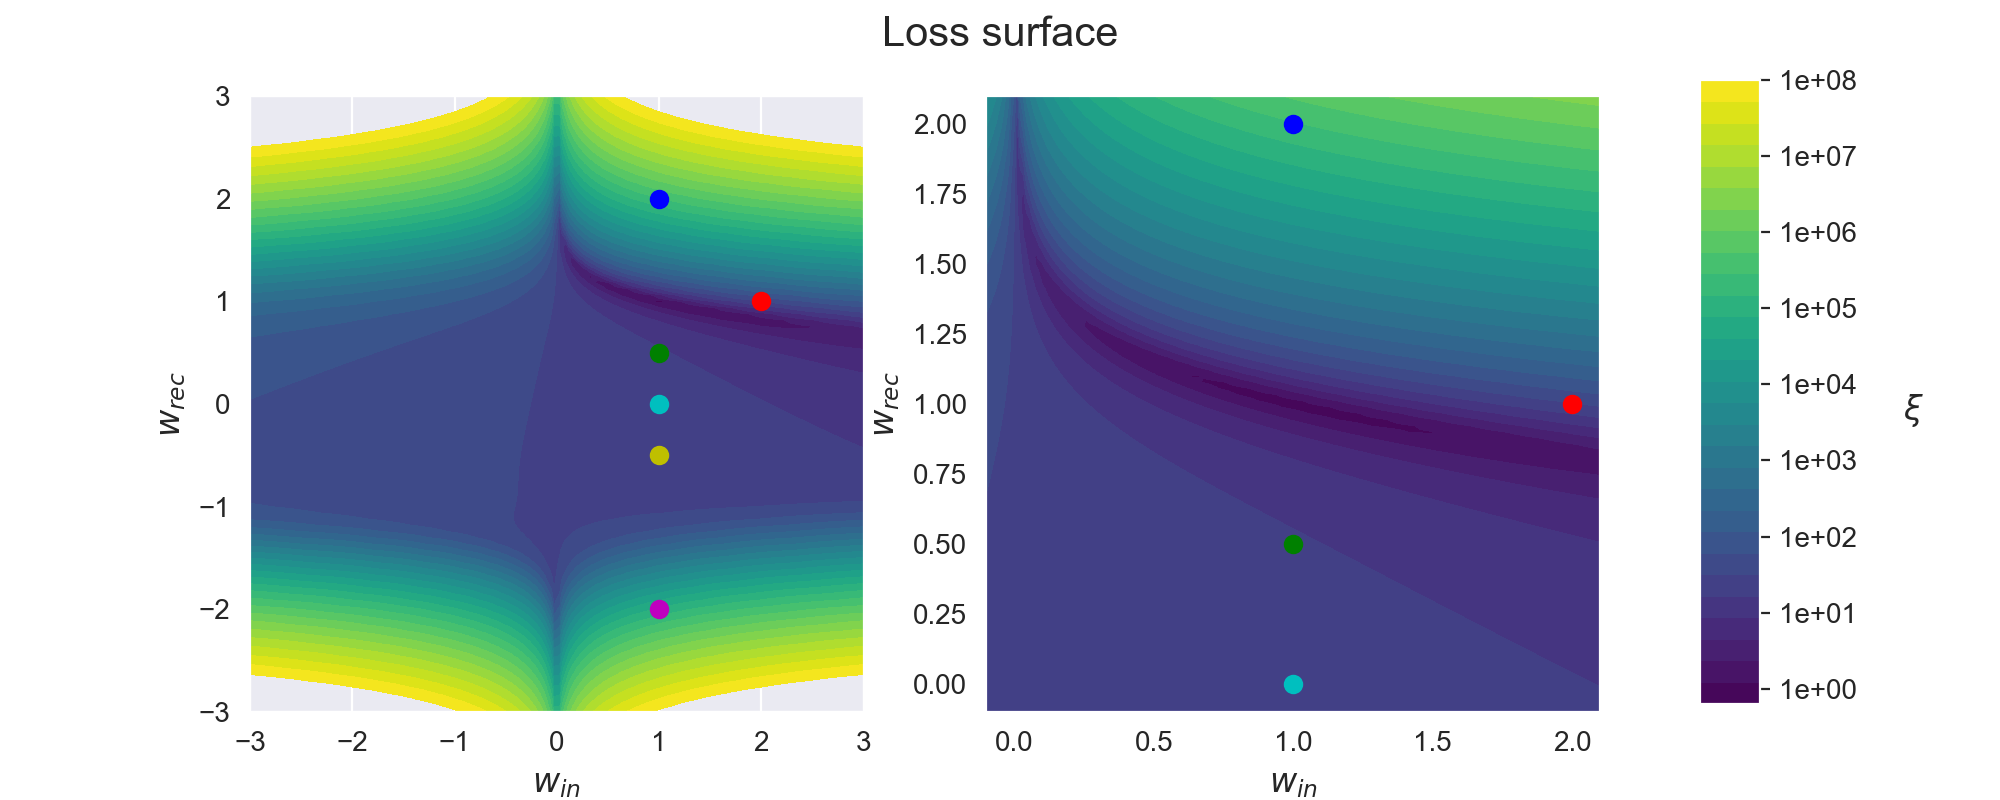

<IPython.core.display.Javascript object>


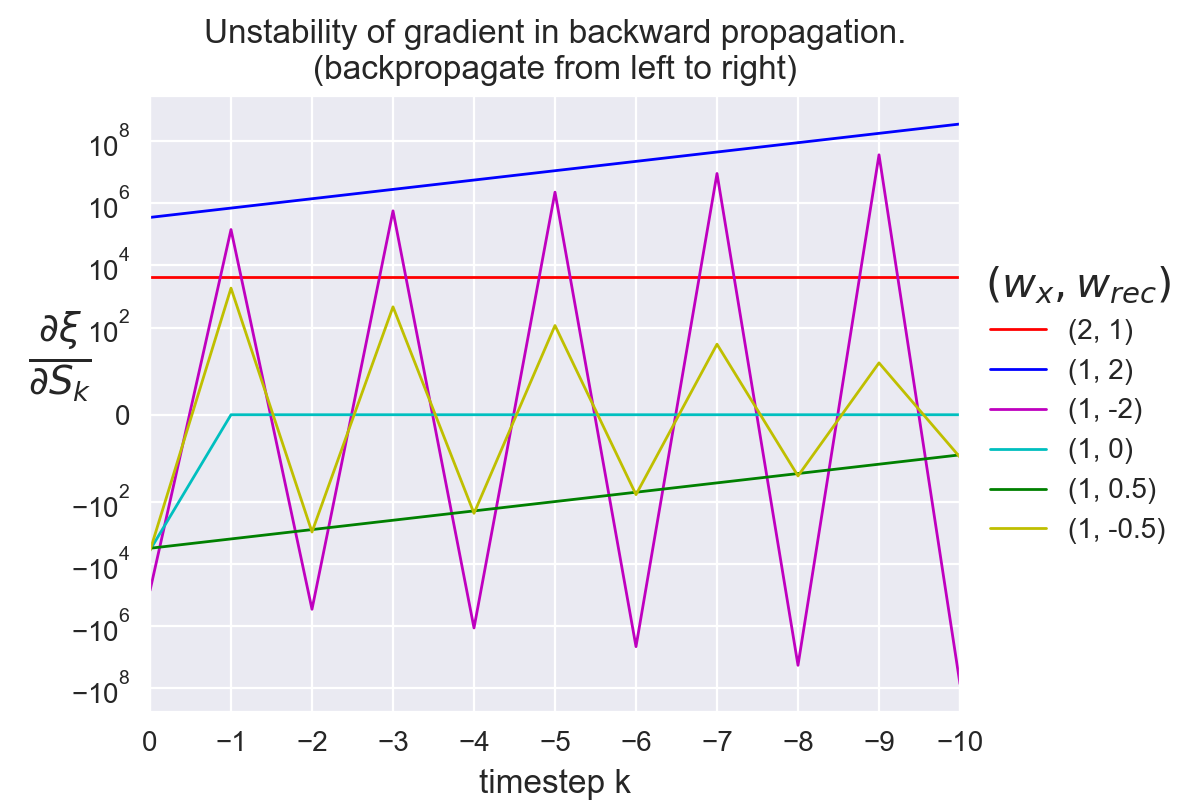

In [7]:
# Plot loss surface and gradients

# Get and plot the loss surface figure with markers
fig = get_loss_surface_figure(
    lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t), points)

# Get the plots of the gradients changing by backpropagating.
plot_gradient_over_time(points, get_grad_over_time)
# Show figures
plt.show()
#

### Rprop optimisation

The previous section illustrated that the gradient can be highly unstable. Entering an area of unstable gradients could result in a huge jump on the loss surface, where the optimizer might end up far from the original point. This is illustrated in the following figure (from [Pascanu et al.](http://www.jmlr.org/proceedings/papers/v28/pascanu13.pdf)):

![Illustration exploding gradient from "On the difficulty of training Recurrent Neural Networks", Razvan Pascanu](/images/RNN_implementation/ExplodingGradient_Razvan.png)

Remember from the [previous tutorial on feedforward nets]({% post_url 2015-06-10-neural-network-implementation-part01 %}) that the gradient descent update rule was:

$$
W(i+1) = W(i) - \mu \frac{\partial \xi}{\partial W(i)}
$$

With $W(i)$ the value of $W$ at iteration $i$ during the gradient descent, and $\mu$ the learning rate. 

If during training we would end up in the blue point in the surface plot above above ($w_x\!=\!1, w_{rec}\!=\!2$) the gradient would be in the order of $10^7$. Even with a small learning rate of $0.000001$ ($10^{-6}$) the parameters $W$ would be updated a distance 10 units from its current position, which would be catastrophic in our example. One way do deal with this is to lower the learning rate even more, but if then the optimisation enters a low gradient area the updates wouldn't move at all.

Researchers have found many ways to do gradient based training in this unstable environment. Some examples are: [Gradient clipping](http://arxiv.org/pdf/1211.5063v2.pdf), [Hessian-Free Optimization](http://www.icml-2011.org/papers/532_icmlpaper.pdf), [Momentum](http://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf), etc.

We can handle the unstable gradients by making the optimisation updates less sensitive to the gradients. One way to do this is by using a technique called [resilient backpropagation (Rprop)](https://en.wikipedia.org/wiki/Rprop). Rprop is similar to the momentum method we described in a [previous tutorial]({% post_url 2015-06-10-neural-network-implementation-part04 %}#Backpropagation-updates-with-momentum) but uses only the sign of the gradient to update the parameters. The Rprop algorithm can be summarised as follows:

* Set initial weight update value $\Delta$ to a nonzero value.
* For each parameter $w$:
  * If the sign of the weight's gradient changes compared to the previous iteration:  
  $sign(\partial \xi /\partial w(i)) \neq sign(\partial \xi /\partial w(i-1))$
    * Multiply the weight update value $\Delta$ by $\eta^-$, with $\eta^- < 1$.  
    $\Delta(i) = \Delta(i) * \eta^-$   
  * Else if the sign of the gradient stays the same:  
  $sign(\partial \xi /\partial w(i)) = sign(\partial \xi /\partial w(i-1))$
    * Multiply the weight update value $\Delta$ by $\eta^+$, with $\eta^+ > 1$.  
    $\Delta(i) = \Delta(i) * \eta^+$
  * Update the weight with its weight update value $\Delta$ in the oposite direction of its gradient.
  $w(i+1) = w(i) - sign(\partial \xi /\partial w(i))* \Delta(i)$
  
The hyperparameters are usually set as $\eta^+ = 1.2$ and $\eta^- = 0.5$. If we compare this with the momentum method then this means that if the sign of the gradient doesn't change that we increase the weight update value with 20%. And if the sign of the gradient changes (update passes through a minima) then we decrease the weight update value by half. Note that the weight update value $\Delta$ is similar to the momentum parameter, the difference is that the weight update value only reflects the size of the moment for each parameter. The direction is determined by the sign of the current gradient.

We optimised our simple model with Rprop for 500 iterations. The updates are plotted on the loss surface below as blue dots. Note that even though the weight parameters start out in a high loss and high gradient position that Rprop can still approximate the (1, 1) minimum at the end of our iterations.

In [8]:
# Define Rprop optimisation function
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Update Rprop values in one iteration.
    Args:
        X: input data.
        t: targets.
        W: Current weight parameters.
        W_prev_sign: Previous sign of the W gradient.
        W_delta: Rprop update values (Delta).
        eta_p, eta_n: Rprop hyperparameters.
    Returns:
        (W_delta, W_sign): Weight update and sign of last weight
                           gradient.
    """
    # Perform forward and backward pass to get the gradients
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)  # Sign of new gradient
    # Update the Delta (update value) for each weight 
    #  parameter seperately
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

In [9]:
# Perform Rprop optimisation

# Set hyperparameters
eta_p = 1.2
eta_n = 0.5

# Set initial parameters
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Update values (Delta) for W
W_sign = [0, 0]  # Previous sign of W

ls_of_ws = [(W[0], W[1])]  # List of weights to plot
# Iterate over 500 iterations
for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(
        X, t, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))  # Add weights to list to plot

print(f'Final weights are: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')

Final weights are: wx = 1.0014,  wRec = 0.9997


<IPython.core.display.Javascript object>


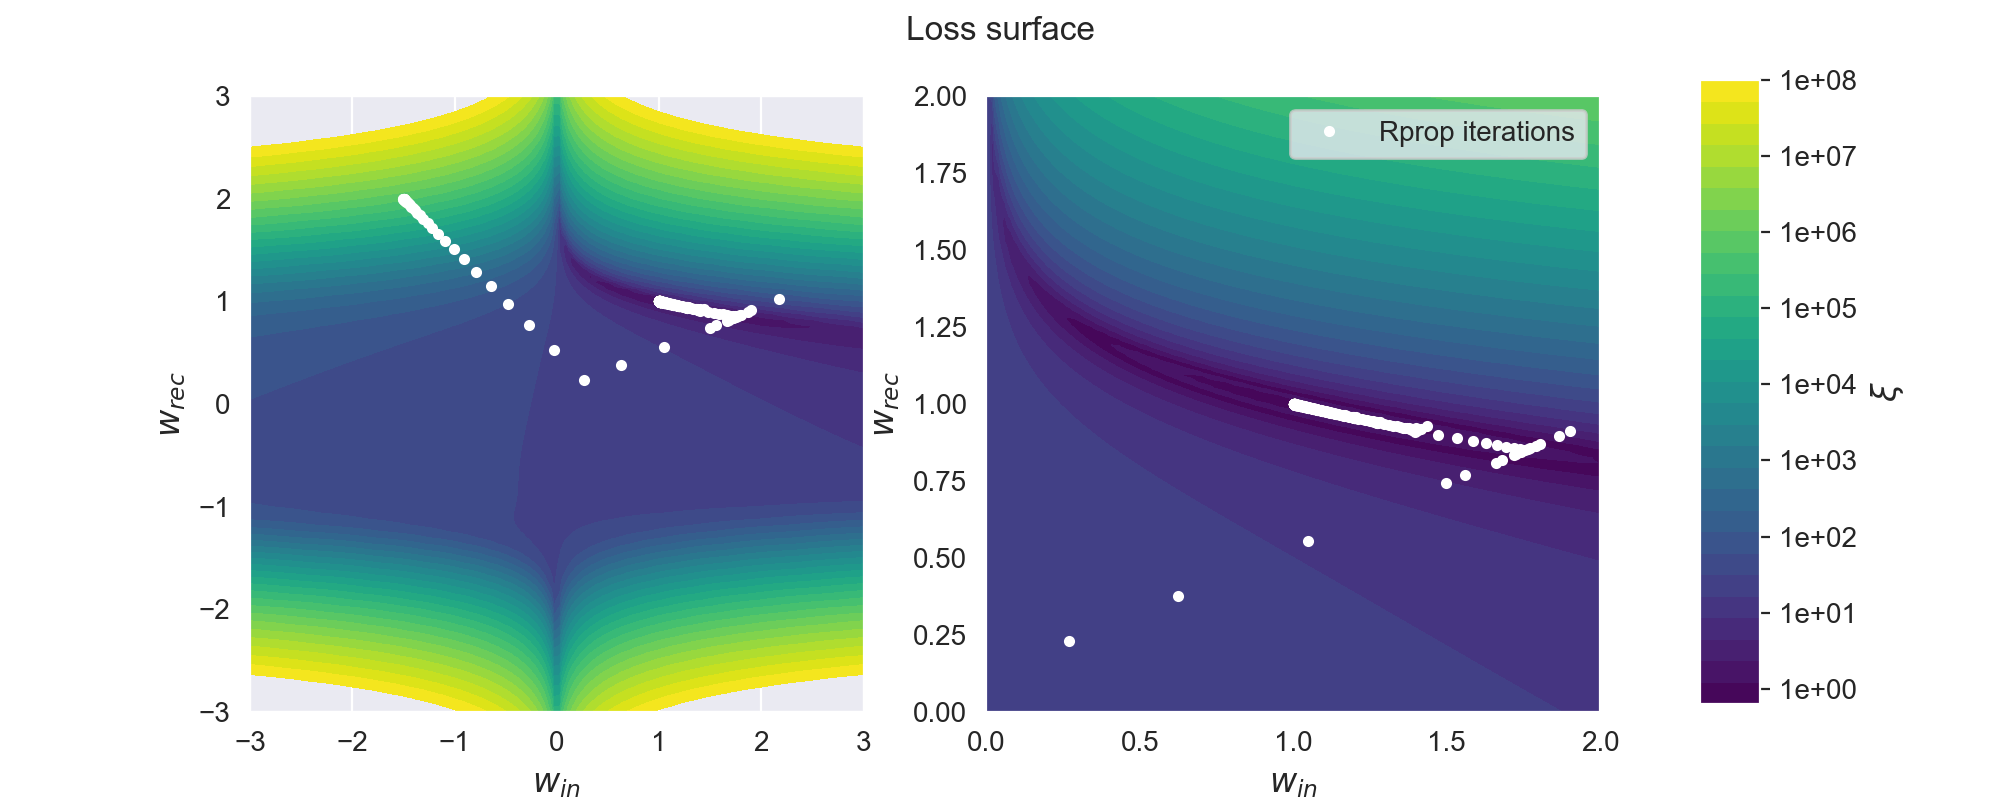

In [10]:
# Plot the loss surface with the weights over the iterations.

# Define plot function
def plot_optimisation(ls_of_ws, loss_func):
    """Plot the optimisation iterations on the loss surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 100, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    ax_1.plot(ws1, ws2, 'wo', markersize=3)
    ax_1.set_xlim([-3, 3])
    ax_1.set_ylim([-3, 3])
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        0, 2, 0, 2, 100, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    ax_2.set_xlim([0, 2])
    ax_2.set_ylim([0, 2])
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2)
    ax_2.plot(ws1, ws2, 'wo', 
              label='Rprop iterations', markersize=3)
    ax_2.legend()
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=12)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Loss surface', fontsize=12)
    plt.show()
    
# Plot the optimisation
plot_optimisation(
    ls_of_ws, lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t))
plt.show()
#

## Final model

The final model is tested on a test sequence below. Note that the output is very close to the target output and that if we round the output to the nearest integer that the output would be perfect.

In [11]:
test_inpt = np.asmatrix([[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]])
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
    f'Target output: {sum_test_inpt:d} vs Model output: '
    f'{test_outpt[0]:.2f}'))
#

Target output: 5 vs Model output: 5.00


In [12]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.0
numpy: 1.15.2
matplotlib: 3.0.0
seaborn: 0.9.0


This is the first part of a 2-part tutorial on how to implement an RNN from scratch in Python:
- [Part 1: Simple RNN (this)]({% post_url 2015-09-27-rnn-implementation-part01 %})
- [Part 2: non-linear RNN]({% post_url 2015-09-27-rnn-implementation-part02 %})

This post at <a rel="canonical" href="https://peterroelants.github.io/posts/rnn-implementation-part01/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/RNN_implementation/rnn-implementation-part01.ipynb)